In [1]:
import matplotlib.pyplot as plt
import numpy as np

from experiments.evaluation_flow.shared import GOOGLENET, RESNET_152, MOBILENET, RESNET_18, RESNET_50, PARAM_UPDATE, PARAM_UPDATE_IMPROVED, PROVENANCE
from experiments.plots.util import *

In [2]:
# ROOT_LOG_DIR = '../evaluation_flow/evaluation-flow-results/results'
ROOT_LOG_DIR = '/Users/nils/Downloads/log-dir'
VERSION = 'version'
FINE_TUNED = 'fine-tuned'
OUTDOOR = 'outdoor'
FOOD = 'food'

In [3]:
# get all file sin the directory
all_files = all_files_in_dir(ROOT_LOG_DIR)
node_server_files = [f for f in all_files if 'server' in f or 'node' in f]
# for all files extract the metadata (e.g. what model and dataset is used)
U_IDS = 'u_ids'

files_and_meta = [(extract_file_meta(f), f) for f in node_server_files]
# add a mapping: use_case -> model id
files_and_meta = [({**f[0], **{U_IDS: use_case_ids(f[1])}}, f[1]) for f in files_and_meta]
# add the parsed events
files_and_meta = [({**f[0], **{EVENTS: parse_events(f[1])}}, f[1]) for f in files_and_meta]

In [4]:
valid_joined = join_server_and_node_meta(files_and_meta)

In [5]:
times = extract_times(valid_joined)

In [6]:
def rearrange_u2(use_cases):
    use_cases.sort()
    # remove U_2
    u2 = use_cases.pop(1)
    num_cases = len(use_cases)
    new_u2_pos = int((num_cases - 1) / 2) + 1
    use_cases.insert(new_u2_pos, u2)
    return use_cases


def plot_time_one_model(save_times, save_path=None, ignore_use_cases=[], y_min_max=None):
    use_cases = rearrange_u2(list(save_times.keys()))

    for u in ignore_use_cases:
        use_cases.remove(u)

    plt.rc('font', size=12)
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    times = [save_times[k] for k in use_cases]
    ax.bar(use_cases, times)
    ax.set_ylabel('Time in seconds')
    ax.set_xlabel('Use case description')
    plt.xticks(rotation=45)
    if y_min_max:
        axes = plt.gca()
        axes.set_ylim(y_min_max)
    if save_path:
        fig.savefig(save_path, bbox_inches='tight')
        fig.savefig(save_path + '.pdf', bbox_inches='tight')

    plt.show()

In [7]:
def plot_detailed_times(plot_data, labels, x_labels, save_path=None):
    plt.rc('font', size=12)
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_ylabel('Time in seconds')
    ax.set_xlabel('Use case description')
    plt.xticks(rotation=45)
    bottom = np.zeros(plot_data[0].shape)
    pos = range(len(x_labels))

    for i, l in enumerate(labels):
        d = plot_data[i] * 10 ** -9
        plt.bar(pos, d, label=labels[i], bottom=bottom)
        bottom += d

    plt.xticks(pos, x_labels)
    plt.legend()

    if save_path:
        fig.savefig(save_path, bbox_inches='tight')
        fig.savefig(save_path + '.pdf', bbox_inches='tight')

    plt.show()

In [8]:
def plot_median_detailed_save_times(data, ignore_rest=True, save_path=None):
    x_labels = rearrange_u2(list(data.keys()))
    labels = ['rest', 'pickle parameters', 'hash parameters', 'persist']

    if ignore_rest:
        labels = labels[1:]

    transformed_data = []
    for u in x_labels:
        tmp = list(data[u].values())
        if ignore_rest:
            tmp = tmp[1:]
        else:
            tmp[0] = tmp[0] - sum(tmp[1:])
        transformed_data.append(tmp)

    plot_data = np.array(transformed_data).T
    plot_detailed_times(plot_data, labels, x_labels, save_path)

In [9]:
def plot_median_detailed_recover_times(data, save_path=None):
    x_labels = rearrange_u2(list(data.keys()))
    labels = ['load', 'recover', 'check weights', 'check env']

    transformed_data = []
    for u in x_labels:
        tmp = list(data[u].values())
        tmp[1] = tmp[1] - (tmp[2] + tmp[3])
        transformed_data.append(tmp)

    plot_data = np.array(transformed_data).T

    plot_detailed_times(plot_data, labels, x_labels, save_path)



In [10]:
def plot_median_high_level_save_time(metas, save_path=None, ignore_use_cases=[], y_min_max=None):
    agg = aggregate_fields(metas, aggregate='median', field_key=HIGH_LEVEL_SAVE_TIMES)
    plot_time_one_model(agg[HIGH_LEVEL_SAVE_TIMES], save_path, ignore_use_cases, y_min_max)


In [11]:
def plot_median_high_level_recover_time(metas, save_path=None, ignore_use_cases=[], y_min_max=None):
    agg = aggregate_fields(metas, aggregate='median', field_key=HIGH_LEVEL_RECOVER_TIMES)
    plot_time_one_model(agg[HIGH_LEVEL_RECOVER_TIMES], save_path, ignore_use_cases, y_min_max)

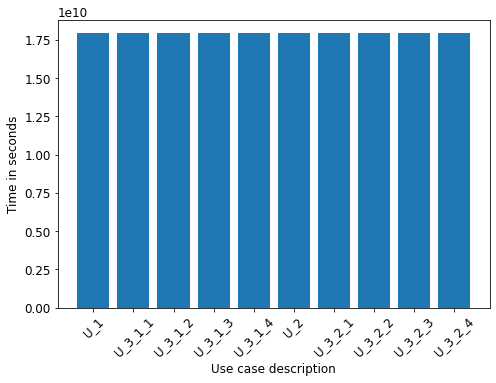

In [12]:
data = filter_meta(times, model=MOBILENET, approach=BASELINE, snapshot_type=VERSION, snapshot_dist=FOOD)
plot_median_high_level_recover_time(data, save_path='./pdfs/baseline/mobilenet-recover-time-version-food')

In [13]:
# BASELINE SAVE TIMES

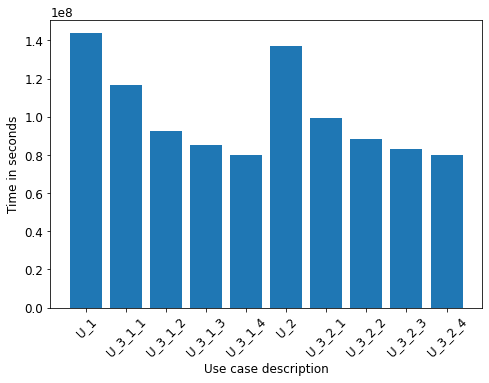

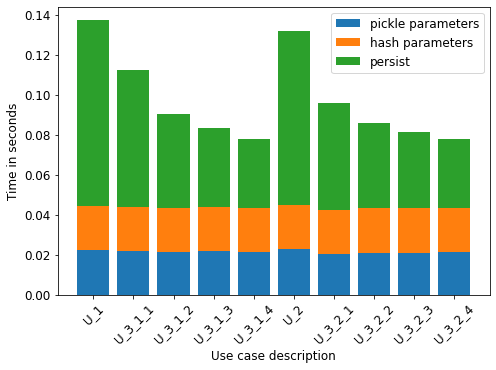

In [14]:
data = filter_meta(times, model=MOBILENET, approach=BASELINE, snapshot_type=VERSION, snapshot_dist=OUTDOOR)
plot_median_high_level_save_time(data, save_path='./pdfs/baseline/mobilenet-save-time-version-food')

median_detailed_save = median_detailed_save_times(data)
plot_median_detailed_save_times(median_detailed_save,
                                save_path='./pdfs/baseline/detailed-mobilenet-save-time-version-food')

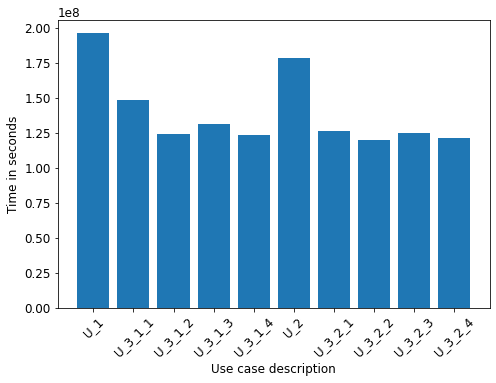

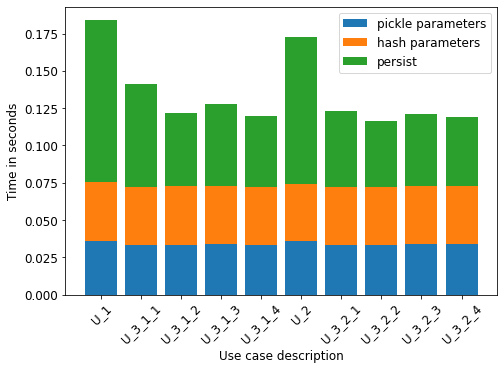

In [15]:
data = filter_meta(times, model=GOOGLENET, approach=BASELINE, snapshot_type=VERSION, snapshot_dist=OUTDOOR)
plot_median_high_level_save_time(data, save_path='./pdfs/baseline/googlenet-save-time-version-food')

median_detailed_save = median_detailed_save_times(data)
plot_median_detailed_save_times(median_detailed_save)

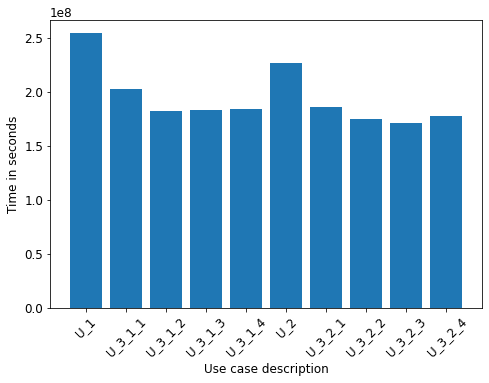

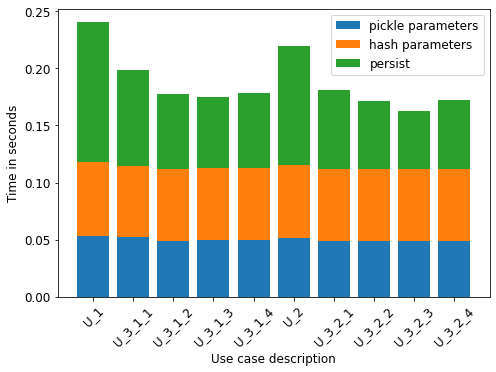

In [16]:
data = filter_meta(times, model=RESNET_18, approach=BASELINE, snapshot_type=VERSION, snapshot_dist=OUTDOOR)
plot_median_high_level_save_time(data, save_path='./pdfs/baseline/resnet18-save-time-version-food')

median_detailed_save = median_detailed_save_times(data)
plot_median_detailed_save_times(median_detailed_save)

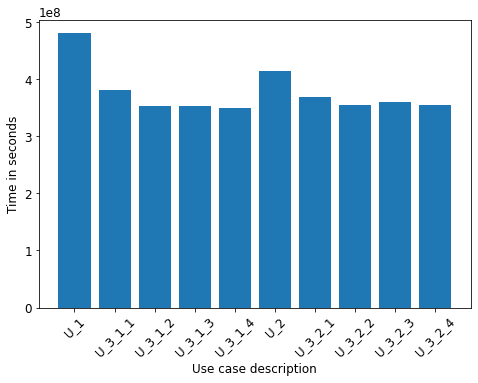

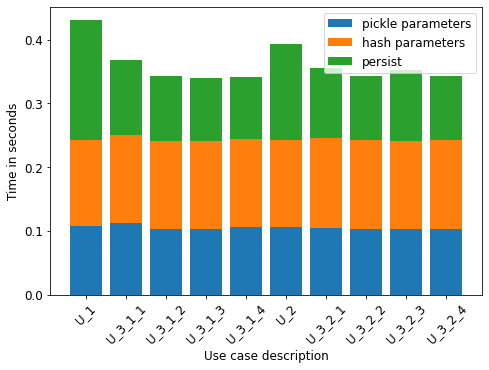

In [17]:
data = filter_meta(times, model=RESNET_50, approach=BASELINE, snapshot_type=VERSION, snapshot_dist=OUTDOOR)
plot_median_high_level_save_time(data, save_path='./pdfs/baseline/resnet50-save-time-version-food')

median_detailed_save = median_detailed_save_times(data)
plot_median_detailed_save_times(median_detailed_save)

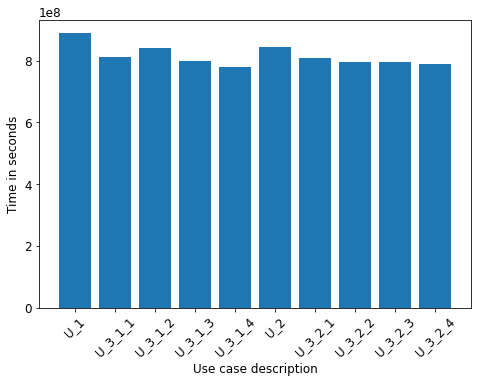

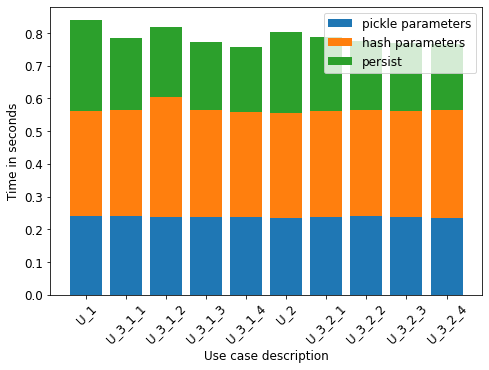

In [18]:
data = filter_meta(times, model=RESNET_152, approach=BASELINE, snapshot_type=VERSION, snapshot_dist=FOOD)
plot_median_high_level_save_time(data, save_path='./pdfs/baseline/resnet152-save-time-version-food')

median_detailed_save = median_detailed_save_times(data)
plot_median_detailed_save_times(median_detailed_save)

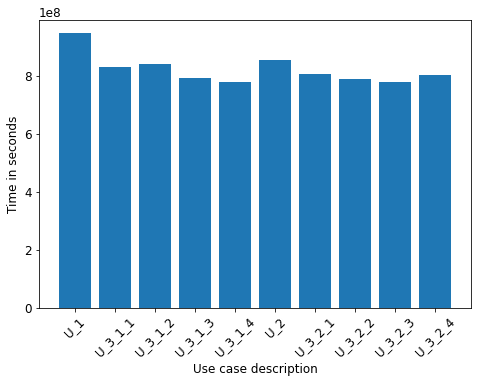

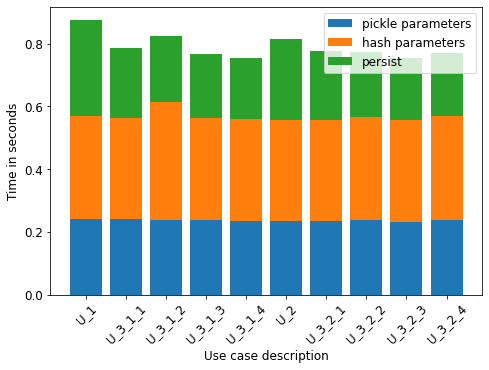

In [19]:
# Save time not dependent on dataset
data = filter_meta(times, model=RESNET_152, approach=BASELINE, snapshot_type=VERSION, snapshot_dist=OUTDOOR)
plot_median_high_level_save_time(data, save_path='./pdfs/baseline/resnet152-save-time-version-outdoor')

median_detailed_save = median_detailed_save_times(data)
plot_median_detailed_save_times(median_detailed_save)

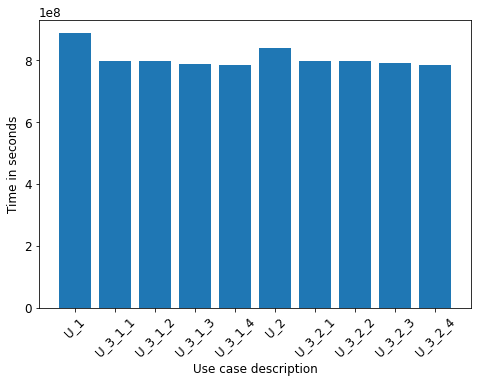

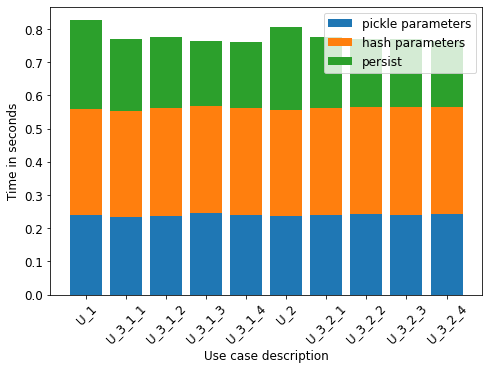

In [20]:
# Save time not dependent on version vs fine-tuned
data = filter_meta(times, model=RESNET_152, approach=BASELINE, snapshot_type=FINE_TUNED, snapshot_dist=OUTDOOR)
plot_median_high_level_save_time(data, save_path='./pdfs/baseline/resnet152-save-time-finetuned-outdoor')

median_detailed_save = median_detailed_save_times(data)
plot_median_detailed_save_times(median_detailed_save)

In [21]:
# BASELINE RECOVER TIMES

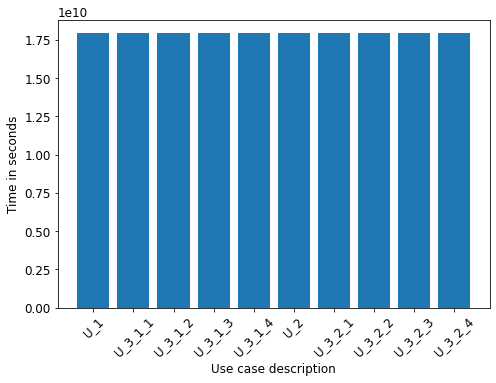

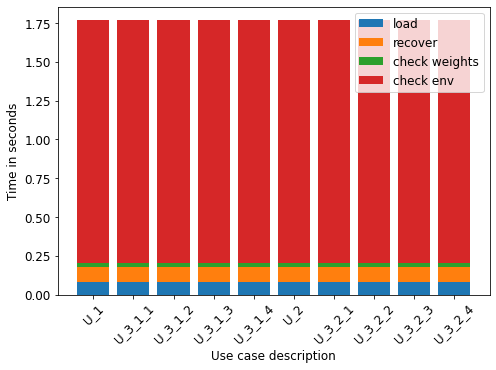

In [22]:
data = filter_meta(times, model=MOBILENET, approach=BASELINE, snapshot_type=VERSION, snapshot_dist=FOOD)
plot_median_high_level_recover_time(data, save_path='./pdfs/baseline/mobilenet-recover-time-version-food')
median_detailed_recover = median_detailed_recover_times(data)
plot_median_detailed_recover_times(median_detailed_recover)

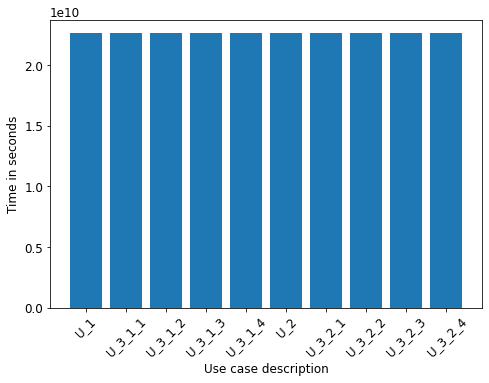

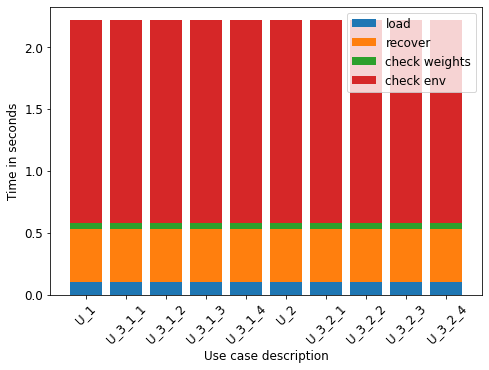

In [23]:
data = filter_meta(times, model=GOOGLENET, approach=BASELINE, snapshot_type=VERSION, snapshot_dist=FOOD)
plot_median_high_level_recover_time(data, save_path='./pdfs/baseline/googlenet-recover-time-version-food')
median_detailed_recover = median_detailed_recover_times(data)
plot_median_detailed_recover_times(median_detailed_recover)

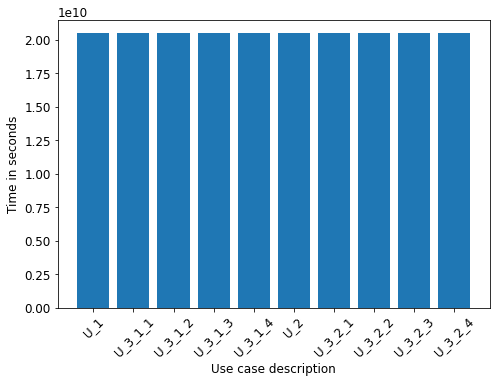

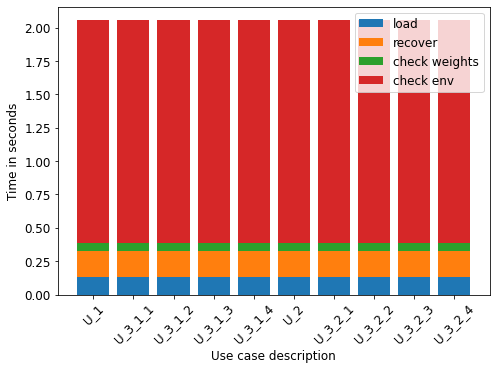

In [24]:
data = filter_meta(times, model=RESNET_18, approach=BASELINE, snapshot_type=VERSION, snapshot_dist=FOOD)
plot_median_high_level_recover_time(data, save_path='./pdfs/baseline/resnet18-recover-time-version-food')
median_detailed_recover = median_detailed_recover_times(data)
plot_median_detailed_recover_times(median_detailed_recover)

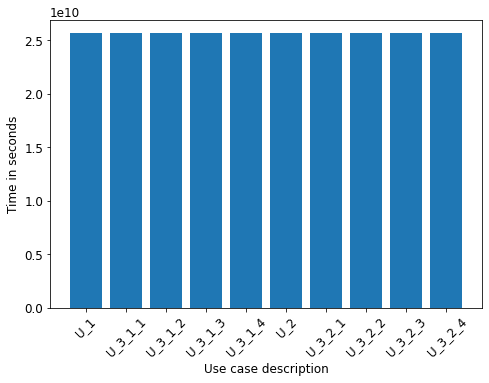

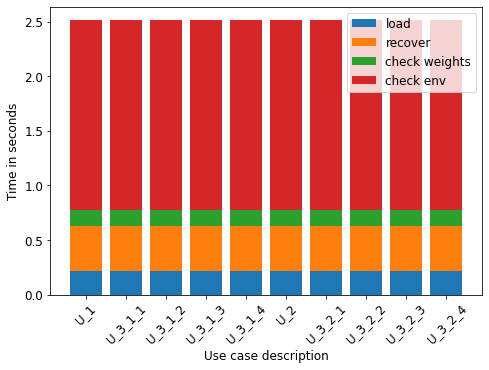

In [25]:
data = filter_meta(times, model=RESNET_50, approach=BASELINE, snapshot_type=VERSION, snapshot_dist=FOOD)
plot_median_high_level_recover_time(data, save_path='./pdfs/baseline/resnet50-recover-time-version-food')
median_detailed_recover = median_detailed_recover_times(data)
plot_median_detailed_recover_times(median_detailed_recover)

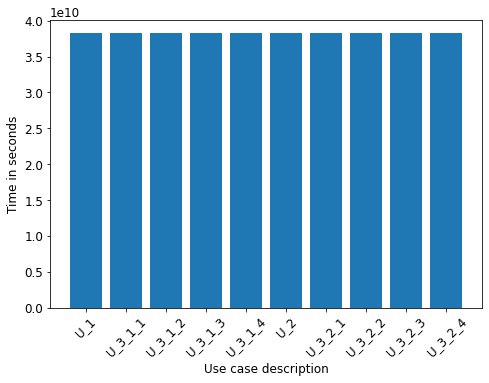

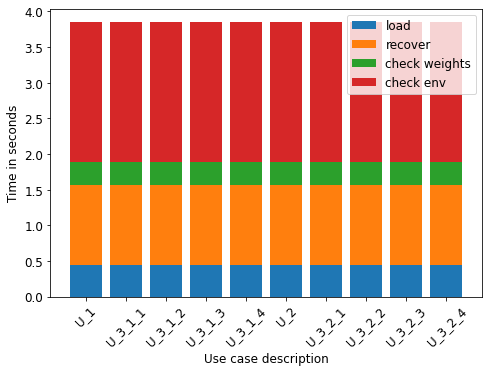

In [26]:
data = filter_meta(times, model=RESNET_152, approach=BASELINE, snapshot_type=VERSION, snapshot_dist=FOOD)
plot_median_high_level_recover_time(data, save_path='./pdfs/baseline/resnet152-recover-time-version-food')
median_detailed_recover = median_detailed_recover_times(data)
plot_median_detailed_recover_times(median_detailed_recover)

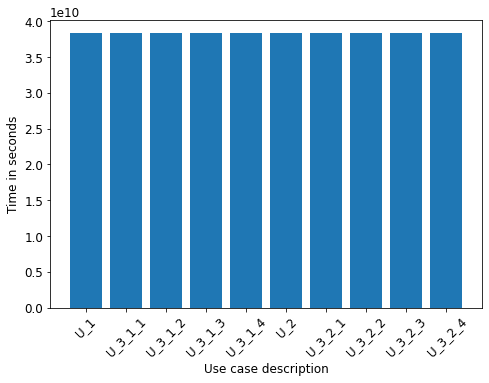

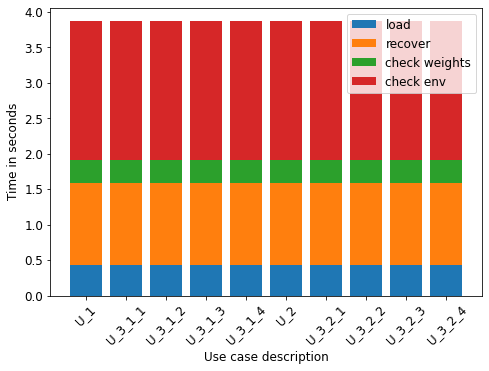

In [27]:
data = filter_meta(times, model=RESNET_152, approach=BASELINE, snapshot_type=VERSION, snapshot_dist=OUTDOOR)
plot_median_high_level_recover_time(data, save_path='./pdfs/baseline/resnet152-recover-time-version-outdoor')
median_detailed_recover = median_detailed_recover_times(data)
plot_median_detailed_recover_times(median_detailed_recover)

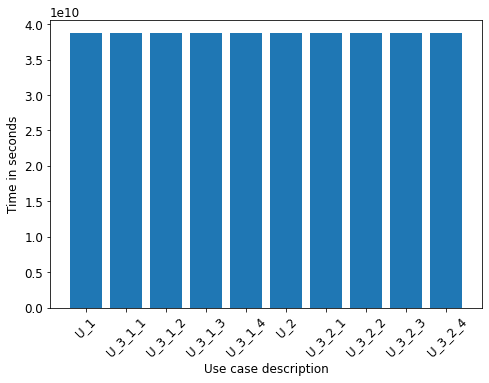

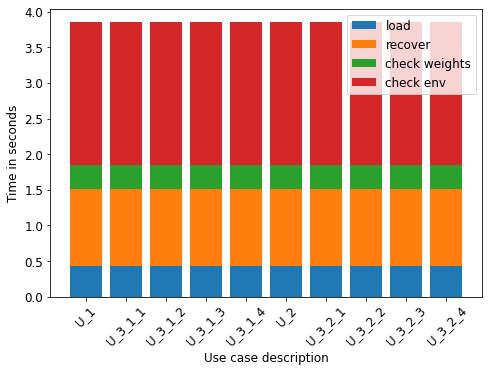

In [28]:
data = filter_meta(times, model=RESNET_152, approach=BASELINE, snapshot_type=FINE_TUNED, snapshot_dist=OUTDOOR)
plot_median_high_level_recover_time(data, save_path='./pdfs/baseline/resnet152-recover-time-finetuned-outdoor')
median_detailed_recover = median_detailed_recover_times(data)
plot_median_detailed_recover_times(median_detailed_recover)

In [29]:
# PARAMETER UPDATE RECOVER TIMES

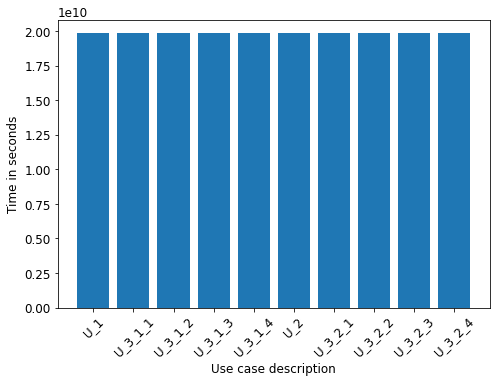

In [30]:
data = filter_meta(times, model=MOBILENET, approach=PARAM_UPDATE, snapshot_type=VERSION, snapshot_dist=FOOD)
plot_median_high_level_recover_time(data, save_path='./pdfs/param-update/mobilenet-recover-time-version-food')

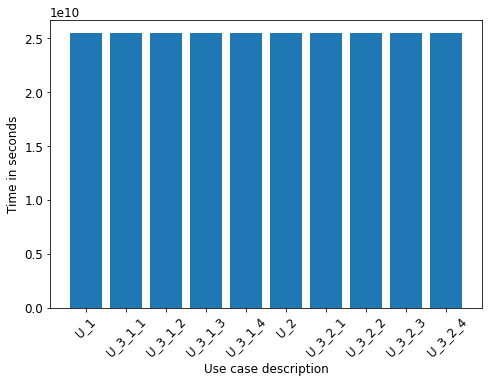

In [31]:
data = filter_meta(times, model=GOOGLENET, approach=PARAM_UPDATE, snapshot_type=VERSION, snapshot_dist=FOOD)
plot_median_high_level_recover_time(data, save_path='./pdfs/param-update/googlenet-recover-time-version-food')

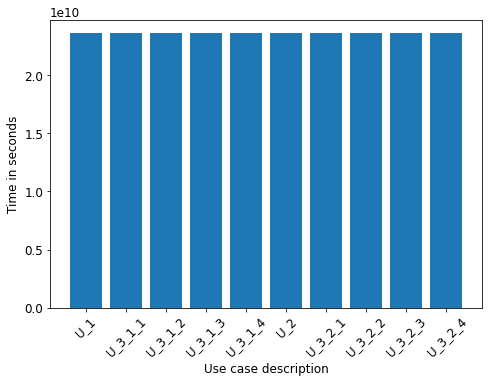

In [32]:
data = filter_meta(times, model=RESNET_18, approach=PARAM_UPDATE, snapshot_type=VERSION, snapshot_dist=FOOD)
plot_median_high_level_recover_time(data, save_path='./pdfs/param-update/resnet18-recover-time-version-food')

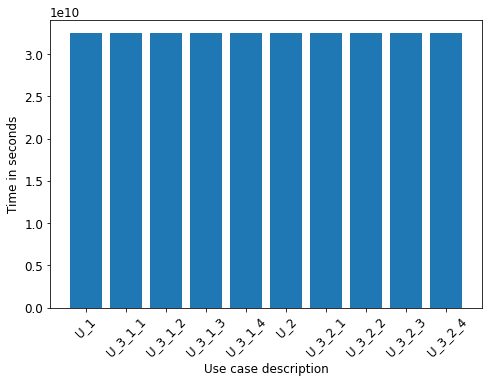

In [33]:
data = filter_meta(times, model=RESNET_50, approach=PARAM_UPDATE, snapshot_type=VERSION, snapshot_dist=FOOD)
plot_median_high_level_recover_time(data, save_path='./pdfs/param-update/resnet50-recover-time-version-food')

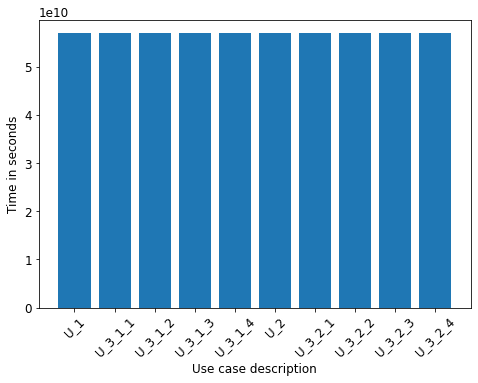

In [34]:
data = filter_meta(times, model=RESNET_152, approach=PARAM_UPDATE, snapshot_type=VERSION, snapshot_dist=FOOD)
plot_median_high_level_recover_time(data, save_path='./pdfs/param-update/resnet152-recover-time-version-food')

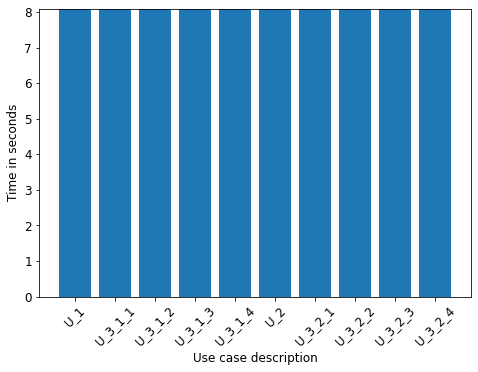

In [35]:
data = filter_meta(times, model=RESNET_152, approach=PARAM_UPDATE, snapshot_type=VERSION, snapshot_dist=OUTDOOR)
plot_median_high_level_recover_time(data, y_min_max=[0, 8.1],
                                    save_path='./pdfs/param-update/resnet152-recover-time-version-outdoor')

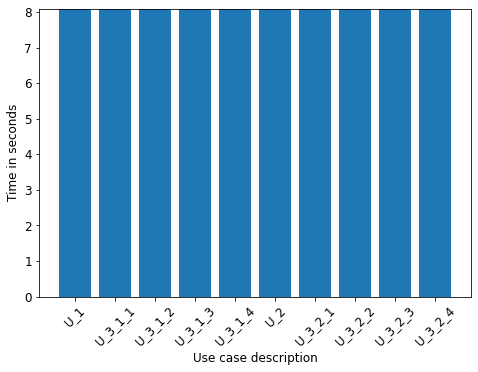

In [36]:
data = filter_meta(times, model=RESNET_152, approach=PARAM_UPDATE, snapshot_type=FINE_TUNED, snapshot_dist=OUTDOOR)
plot_median_high_level_recover_time(data, y_min_max=[0, 8.1],
                                    save_path='./pdfs/param-update/resnet152-recover-time-finetuned-outdoor')

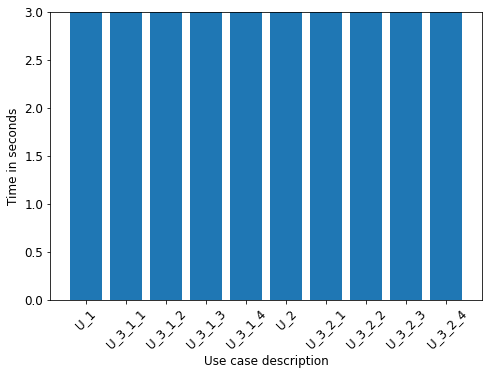

In [37]:
data = filter_meta(times, model=RESNET_18, approach=PARAM_UPDATE, snapshot_type=VERSION, snapshot_dist=OUTDOOR)
plot_median_high_level_recover_time(data, y_min_max=[0, 3],
                                    save_path='./pdfs/param-update/resnet18-recover-time-version-outdoor')

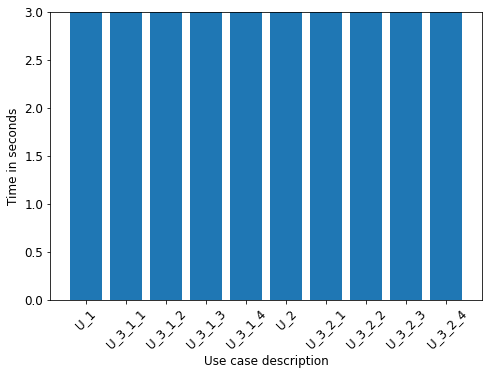

In [38]:
data = filter_meta(times, model=RESNET_18, approach=PARAM_UPDATE, snapshot_type=FINE_TUNED, snapshot_dist=OUTDOOR)
plot_median_high_level_recover_time(data, y_min_max=[0, 3],
                                    save_path='./pdfs/param-update/resnet18-recover-time-finetuned-outdoor')

In [39]:
# PARAMETER UPDATE SAVE TIMES

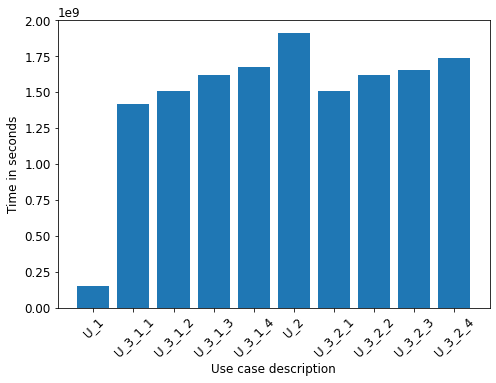

In [40]:
data = filter_meta(times, model=MOBILENET, approach=PARAM_UPDATE, snapshot_type=VERSION, snapshot_dist=FOOD)
plot_median_high_level_save_time(data, save_path='./pdfs/param-update/mobilenet-save-time-version-food')

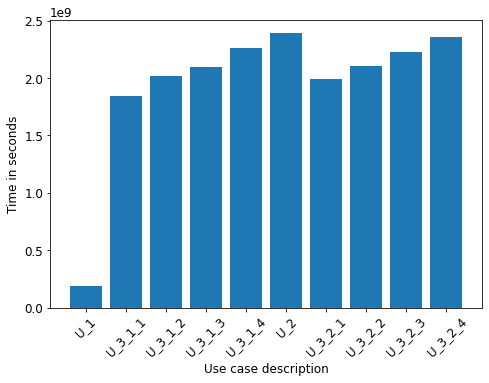

In [41]:
data = filter_meta(times, model=GOOGLENET, approach=PARAM_UPDATE, snapshot_type=VERSION, snapshot_dist=FOOD)
plot_median_high_level_save_time(data, save_path='./pdfs/param-update/googlenet-save-time-version-food')

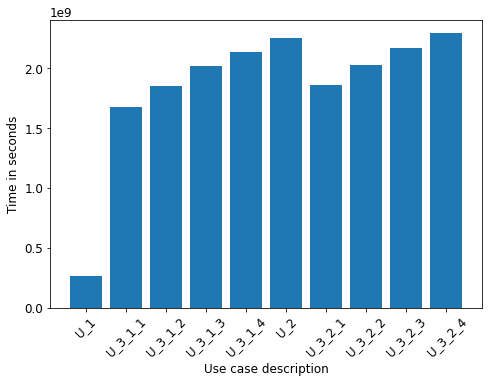

In [42]:
data = filter_meta(times, model=RESNET_18, approach=PARAM_UPDATE, snapshot_type=VERSION, snapshot_dist=FOOD)
plot_median_high_level_save_time(data, save_path='./pdfs/param-update/resnet18-save-time-version-food')

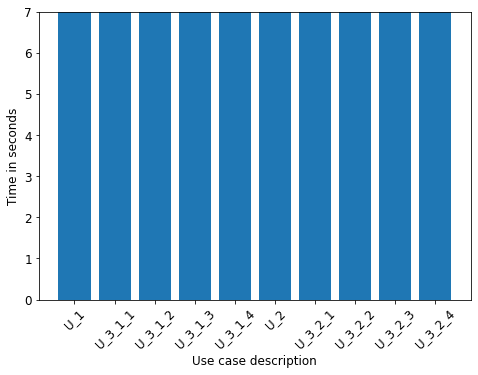

In [43]:
data = filter_meta(times, model=RESNET_50, approach=PARAM_UPDATE, snapshot_type=VERSION, snapshot_dist=FOOD)
plot_median_high_level_save_time(data, y_min_max=[0, 7],
                                 save_path='./pdfs/param-update/resnet50-save-time-version-food')

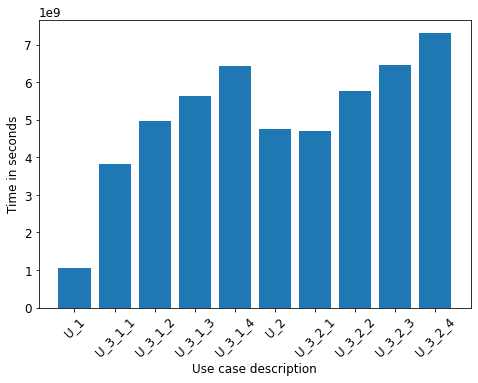

In [44]:
data = filter_meta(times, model=RESNET_152, approach=PARAM_UPDATE, snapshot_type=VERSION, snapshot_dist=FOOD)
plot_median_high_level_save_time(data, save_path='./pdfs/param-update/resnet152-save-time-version-food')


# PARAMETER UPDATE IMPROVED

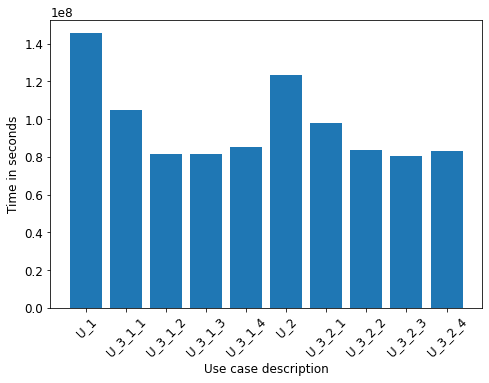

In [45]:
data = filter_meta(times, model=MOBILENET, approach=PARAM_UPDATE_IMPROVED, snapshot_type=VERSION, snapshot_dist=FOOD)
plot_median_high_level_save_time(data, save_path='./pdfs/param-update/improved-mobilenet-save-time-version-food')

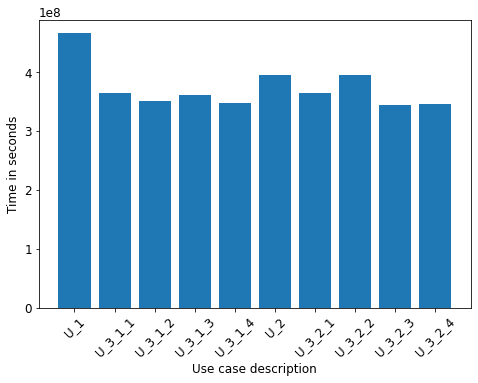

In [46]:
data = filter_meta(times, model=RESNET_50, approach=PARAM_UPDATE_IMPROVED, snapshot_type=VERSION, snapshot_dist=FOOD)
plot_median_high_level_save_time(data, save_path='./pdfs/param-update/improved-resnet50-save-time-version-food')


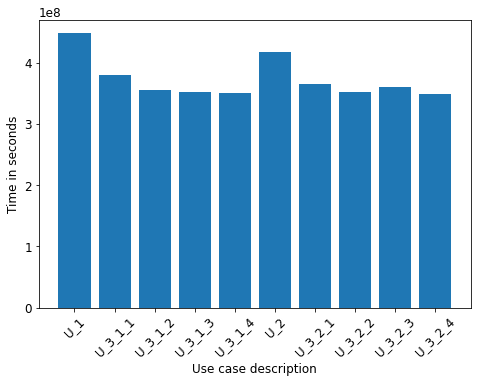

In [47]:
# Compare ot baseline with fixed z axis
data = filter_meta(times, model=RESNET_50, approach=BASELINE, snapshot_type=VERSION, snapshot_dist=FOOD)
plot_median_high_level_save_time(data, save_path='./pdfs/param-update/baseline-fixedy-resnet50-save-time-version-food')


# Compare recover times

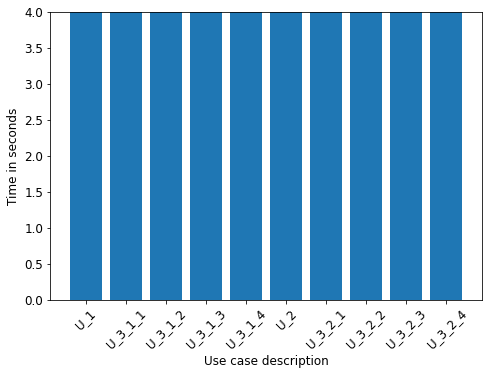

In [48]:
data = filter_meta(times, model=RESNET_50, approach=BASELINE, snapshot_type=VERSION, snapshot_dist=FOOD)
plot_median_high_level_recover_time(data, y_min_max=[0, 4],
                                    save_path='./pdfs/comparisons/baseline-resnet50-recover-time-version-food')

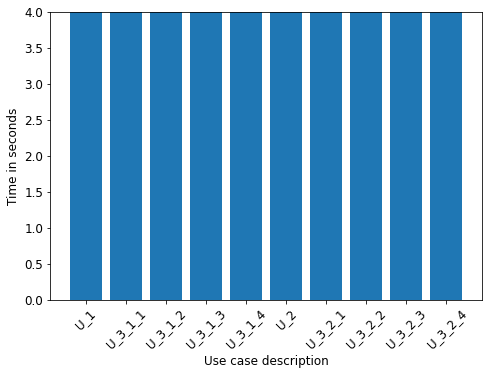

In [49]:
data = filter_meta(times, model=RESNET_50, approach=PARAM_UPDATE, snapshot_type=VERSION, snapshot_dist=FOOD)
plot_median_high_level_recover_time(data, y_min_max=[0, 4],
                                    save_path='./pdfs/comparisons/paramupdate-resnet50-recover-time-version-food')

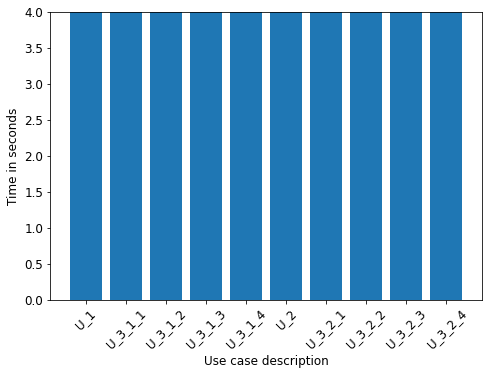

In [50]:
data = filter_meta(times, model=RESNET_50, approach=PARAM_UPDATE_IMPROVED, snapshot_type=VERSION, snapshot_dist=FOOD)
plot_median_high_level_recover_time(data, y_min_max=[0, 4],
                                    save_path='./pdfs/comparisons/paramupdateimproved-resnet50-recover-time-version-food')

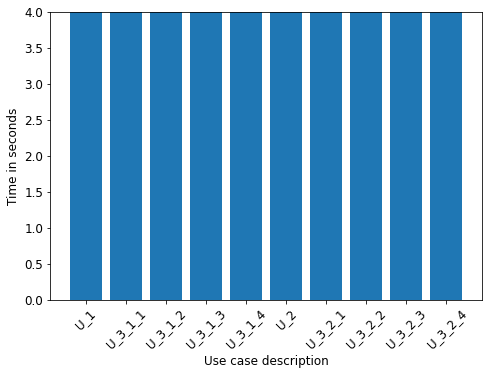

In [51]:
data = filter_meta(times, model=RESNET_50, approach=BASELINE, snapshot_type=FINE_TUNED, snapshot_dist=FOOD)
plot_median_high_level_recover_time(data, y_min_max=[0, 4],
                                    save_path='./pdfs/comparisons/baseline-resnet50-recover-time-finetuned-food')

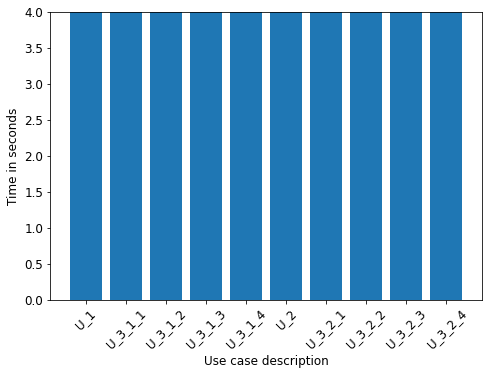

In [52]:
data = filter_meta(times, model=RESNET_50, approach=PARAM_UPDATE, snapshot_type=FINE_TUNED, snapshot_dist=FOOD)
plot_median_high_level_recover_time(data, y_min_max=[0, 4],
                                    save_path='./pdfs/comparisons/paramupdate-resnet50-recover-time-finetuned-food')

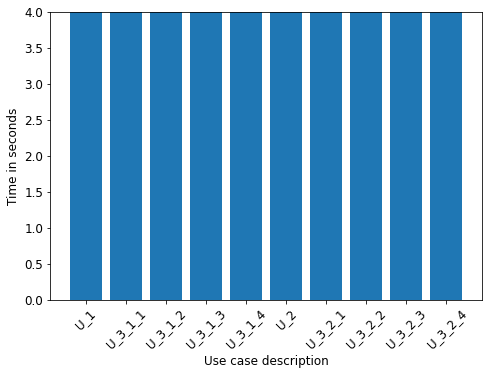

In [53]:
data = filter_meta(times, model=RESNET_50, approach=PARAM_UPDATE_IMPROVED, snapshot_type=FINE_TUNED, snapshot_dist=FOOD)
plot_median_high_level_recover_time(data, y_min_max=[0, 4],
                                    save_path='./pdfs/comparisons/paramupdateimproved-resnet50-recover-time-finetuned-food')


In [54]:
# PROVENANCE APPROACH SAVE TIME

In [55]:
data = filter_meta(times, model=MOBILENET, approach=PROVENANCE, snapshot_type=FINE_TUNED, snapshot_dist=FOOD)
plot_median_high_level_save_time(data, save_path='./pdfs/provenance/mobilenet-save-time-finetuned-food',
                                 ignore_use_cases=[U_1, U_2])

IndexError: list index out of range

In [ ]:
data = filter_meta(times, model=GOOGLENET, approach=PROVENANCE, snapshot_type=FINE_TUNED, snapshot_dist=FOOD)
plot_median_high_level_save_time(data, save_path='./pdfs/provenance/googlenet-save-time-finetuned-food',
                                 ignore_use_cases=[U_1, U_2])

In [ ]:
data = filter_meta(times, model=RESNET_18, approach=PROVENANCE, snapshot_type=FINE_TUNED, snapshot_dist=FOOD)
plot_median_high_level_save_time(data, save_path='./pdfs/provenance/resnet18-save-time-finetuned-food',
                                 ignore_use_cases=[U_1, U_2])

In [ ]:
data = filter_meta(times, model=RESNET_50, approach=PROVENANCE, snapshot_type=FINE_TUNED, snapshot_dist=FOOD)
plot_median_high_level_save_time(data, save_path='./pdfs/provenance/resnet50-save-time-finetuned-food',
                                 ignore_use_cases=[U_1, U_2])

In [ ]:
data = filter_meta(times, model=RESNET_152, approach=PROVENANCE, snapshot_type=FINE_TUNED, snapshot_dist=FOOD)
plot_median_high_level_save_time(data, save_path='./pdfs/provenance/resnet152-save-time-finetuned-food',
                                 ignore_use_cases=[U_1, U_2])

# COMPARE IMPACT OF DATASET

In [ ]:
data = filter_meta(times, model=MOBILENET, approach=PROVENANCE, snapshot_type=FINE_TUNED, snapshot_dist=FOOD)
plot_median_high_level_save_time(data, y_min_max=[0, 3],
                                 save_path='./pdfs/comparisons/prov-mobilenet-save-time-finetuned-food',
                                 ignore_use_cases=[U_1, U_2])

In [ ]:
data = filter_meta(times, model=RESNET_50, approach=PROVENANCE, snapshot_type=FINE_TUNED, snapshot_dist=FOOD)
plot_median_high_level_save_time(data, y_min_max=[0, 3],
                                 save_path='./pdfs/comparisons/prov-resnet50-save-time-finetuned-food',
                                 ignore_use_cases=[U_1, U_2])

In [ ]:
data = filter_meta(times, model=MOBILENET, approach=PROVENANCE, snapshot_type=FINE_TUNED, snapshot_dist=OUTDOOR)
plot_median_high_level_save_time(data, y_min_max=[0, 3],
                                 save_path='./pdfs/comparisons/prov-mobilenet-save-time-finetuned-outdoor',
                                 ignore_use_cases=[U_1, U_2])

In [ ]:
data = filter_meta(times, model=RESNET_50, approach=PROVENANCE, snapshot_type=FINE_TUNED, snapshot_dist=OUTDOOR)
plot_median_high_level_save_time(data, y_min_max=[0, 3],
                                 save_path='./pdfs/comparisons/prov-resnet50-save-time-finetuned-outdoor',
                                 ignore_use_cases=[U_1, U_2])


In [ ]:
data = filter_meta(times, model=RESNET_50, approach=PROVENANCE, snapshot_type=FINE_TUNED, snapshot_dist=OUTDOOR)
plot_median_high_level_save_time(data, save_path='./pdfs/comparisons/prov-resnet50-save-time-finetuned-outdoor-withu2',
                                 ignore_use_cases=[U_1])

In [ ]:
# PROVENANCE APPROACH RECOVER TIME

In [ ]:
data = filter_meta(times, model=MOBILENET, approach=PROVENANCE, snapshot_type=VERSION, snapshot_dist=FOOD)
plot_median_high_level_recover_time(data, save_path='./pdfs/provenance/mobilenet-recover-time-version-food',
                                    ignore_use_cases=[U_1])

In [ ]:
data = filter_meta(times, model=GOOGLENET, approach=PROVENANCE, snapshot_type=VERSION, snapshot_dist=FOOD)
plot_median_high_level_recover_time(data, save_path='./pdfs/provenance/googlenet-recover-time-version-food',
                                    ignore_use_cases=[U_1])

In [ ]:
data = filter_meta(times, model=RESNET_18, approach=PROVENANCE, snapshot_type=VERSION, snapshot_dist=FOOD)
plot_median_high_level_recover_time(data, save_path='./pdfs/provenance/resnet18-recover-time-version-food',
                                    ignore_use_cases=[U_1])

In [ ]:
data = filter_meta(times, model=RESNET_50, approach=PROVENANCE, snapshot_type=VERSION, snapshot_dist=FOOD)
plot_median_high_level_recover_time(data, save_path='./pdfs/provenance/resnet50-recover-time-version-food',
                                    ignore_use_cases=[U_1])

In [ ]:
data = filter_meta(times, model=RESNET_152, approach=PROVENANCE, snapshot_type=VERSION, snapshot_dist=FOOD)
plot_median_high_level_recover_time(data, save_path='./pdfs/provenance/resnet152-recover-time-version-food',
                                    ignore_use_cases=[U_1])

In [ ]:
# # set width of bars
# barWidth = 0.1
#
# bars = {}
# for m in MODELS:
#     times = save_times[m]
#     for use_case, time in times.items():
#         if use_case in bars:
#             bars[use_case].append(time)
#         else:
#             bars[use_case] = [time]
#
# # Set position of bar on X axis
# # l = len(bars[U_1])
# # print(l)
# # positions = [np.arange(l)]
# # for i in range(1, len(bars)):
# #     prev_positions = positions[-1]
# #     positions.append(prev_positions)
#
# r1 = np.arange(5)
# r2 = [x + barWidth for x in r1]
# r3 = [x + barWidth for x in r2]
# r4 = [x + barWidth for x in r3]
# r5 = [x + barWidth for x in r4]
# r6 = [x + barWidth for x in r5]
# r7 = [x + barWidth for x in r6]
# r8 = [x + barWidth for x in r7]
# r9 = [x + barWidth for x in r8]
# r10 = [x + barWidth for x in r9]
# positions = [r1, r2, r3, r4, r5, r6, r7, r8, r9, r10]
#
# colors = ['orange', 'red', 'green', 'blue', 'yellow', 'orange', 'red', 'green', 'blue', 'yellow']
#
# for position, bar, color, label in zip(positions, list(bars.values())[:], colors, list(bars.keys())[:]):
#     plt.bar(position, bar, color=color, width=barWidth, edgecolor='white', label=label)
#
# # # Add xticks on the middle of the group bars
# # plt.xlabel('group', fontweight='bold')
# # plt.xticks([r + barWidth for r in range(len(bars1))], ['A', 'B', 'C', 'D', 'E'])
#
# # Create legend & Show graphic
# plt.legend()
# plt.show()
#

In [ ]:
# meta, events = baseline_version_food_server_0[0]
# e_u1 = events[0]
# e_u2 = events[5]
# print(e_u1)
# print(e_u2)
#
#
#

In [ ]:
# meta, events = extract_event_and_and_meta('/Users/nils/Downloads/test-env-log.txt')
#

In [ ]:
# for e in events:
#     print(e)
#